In [1]:
import numpy as np
np.random.seed(10)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

#import DL libs
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers 
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import LSTM, GRU
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
%matplotlib inline

Using TensorFlow backend.
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [25]:
def plot_distributions(X):
    """
    plots distribution of numerical data from dataframe
    """
    X = pd.melt(X)
    g = sns.FacetGrid(X, col="variable",  col_wrap=3, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")
    
def plot_missing_values(X):
    """
    plots missing values per column of  dataframe in a bar chart 
    """
    missing = X.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    
def spearman(frame, features=[], target='y'):
    """
    plots spearman correlation of each features with target
    """
    spr = pd.DataFrame()
    print(features)
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
    
def plot_corr_heatmap(X, title="Corr Heatmap"):
    X_corr = X.corr()
    plt.figure(figsize=(16,7))
    # Add title
    plt.title(title)
    mask = np.zeros_like(X_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(mask=mask, data=X_corr, annot=True, cmap=cmap)
    
def pairplot_with_target(X, features, target):
    def pairplot(x, y, **kwargs):
        ax = plt.gca()
        ts = pd.DataFrame({'time': x, 'val': y})
        ts = ts.groupby('time').mean()
        ts.plot(ax=ax)
        plt.xticks(rotation=90)

    f = pd.melt(X, id_vars=[target], value_vars=features)
    g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
    g = g.map(pairplot, "value", target)

## PART 1

            PRICE  TRD_VOLUME  MINERS_FEE  TRAN_VOL  PRICE_VOL  \
2010-01-01    0.0         0.0         0.0       0.0        NaN   
2010-01-02    0.0         0.0         0.0     100.0        NaN   
2010-01-03    0.0         0.0         0.0       0.0        NaN   
2010-01-04    0.0         0.0         0.0   20778.0        NaN   
2010-01-05    0.0         0.0         0.0       0.0        NaN   

            MINERS_REVENUE  DIFFICULTY  TRAN_BLOCK  HASH_RATE  MONEY_SUPPLY  \
2010-01-01          6900.0         1.0         1.0   0.000008     1624700.0   
2010-01-02          6600.0         1.0         1.0   0.000008     1631300.0   
2010-01-03          6300.0         1.0         1.0   0.000007     1637600.0   
2010-01-04          9300.0         1.0         1.0   0.000007     1646900.0   
2010-01-05          9050.0         1.0         1.0   0.000008     1655950.0   

            BCH_PRICE  
2010-01-01        0.0  
2010-01-02        0.0  
2010-01-03        0.0  
2010-01-04        0.0  
2010-01-

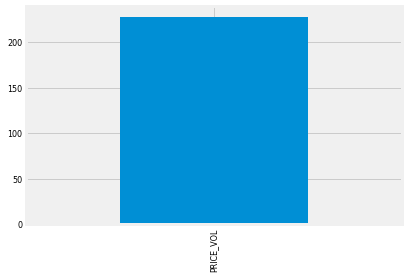

In [58]:
#read datasets
btc_price = pd.read_csv('../data/BTCPrice.csv', index_col=['Date'])
btc_price.columns = ['PRICE']

btc_trd_vol = pd.read_csv('../data/BTCTradeVolume.csv', index_col=['Date'])
btc_trd_vol.columns = [ 'TRD_VOLUME']

btc_miner_fees =  pd.read_csv('../data/BTCtransaction-fees.csv', index_col=['Date'])
btc_miner_fees.columns = ['MINERS_FEE']


btc_transaction_vol = pd.read_csv('../data/BTCTransactionVolume.csv', index_col=['Date'])
btc_transaction_vol.columns = ['TRAN_VOL']

btc_price_vol = pd.read_csv('../data/BTCprice-volatility.csv', index_col=['Date'])
btc_price_vol.columns = ['PRICE_VOL']

btc_miner_revenue =  pd.read_csv('../data/BTCminer-revenue.csv', index_col=['Date'])
btc_miner_revenue.columns = ['MINERS_REVENUE']

btc_difficulty = pd.read_csv('../data/BTCDifficulty.csv', index_col=['Date'])
btc_difficulty.columns = ['DIFFICULTY']

btc_transaction_per_block = pd.read_csv('../data/BTCTransactionPerBlock.csv', index_col=['Date'])
btc_transaction_per_block.columns = ['TRAN_BLOCK']

btc_hash_rate = pd.read_csv('../data/BTChash-rate.csv', index_col=['Date'])
btc_hash_rate.columns = ['HASH_RATE'] 

bch_price =  pd.read_csv('../data/BCHprice.csv', index_col=['Date'])
bch_price.columns = ['BCH_PRICE']

btc_money_supply =  pd.read_csv('../data/BTCmoney-supply.csv', index_col=['Date'])
btc_money_supply.columns = ['MONEY_SUPPLY']



btc_data = pd.concat([btc_price, btc_trd_vol, btc_miner_fees, btc_transaction_vol, btc_price_vol,
                     btc_miner_revenue, btc_difficulty, btc_transaction_per_block, btc_hash_rate,
                     btc_money_supply, bch_price], axis=1, sort=True)
btc_data.index= pd.to_datetime(btc_data.index, format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data.index >= '2010-01-01') & (btc_data.index <= '2019-06-30')]
print (btc_data.head())
plot_missing_values(btc_data)
btc_data.to_csv('btc_data.csv')
btc_data = btc_data.drop(btc_data[btc_data['PRICE']==0].index)
print (btc_data.describe())

Only PRICE_VOL colum column has missing values.

0 price does not make sense in the beginning of 2010. Its probably due to the lack of trading on exchanges at that time. It would be best to drop rows with 0 price or 0 trade volume. Since prices with 0 trading volume are also not reliable. Removing 0 price value also takes care of the missing value in the price vol column.


### 2)

Text(0.5, 0, 'date')

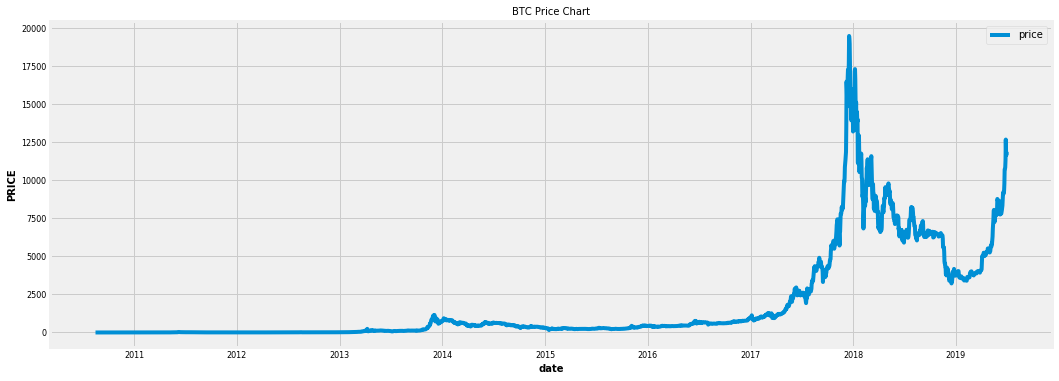

In [4]:
plt.figure(figsize=(16,6))
plt.title('BTC Price Chart')
sns.lineplot(btc_data.index, btc_data['PRICE'], label='price')
plt.xlabel('date')

               PRICE  TRD_VOLUME  MINERS_FEE  TRAN_VOL  PRICE_VOL  \
2010-08-17 -0.448879   -0.313495   -0.534373 -0.614176   3.109663   
2010-08-18 -0.448880   -0.313497   -0.540073 -0.661082   1.865370   
2010-08-19 -0.448882   -0.313496   -0.526801 -0.743868   1.759482   
2010-08-20 -0.448882   -0.313496   -0.540073 -0.716115   1.671825   
2010-08-21 -0.448882   -0.313496   -0.540073 -0.729967   1.671825   

            MINERS_REVENUE  DIFFICULTY  TRAN_BLOCK  HASH_RATE  MONEY_SUPPLY  \
2010-08-17        1.053534   -0.401345   -1.088262  -0.400393     -2.275506   
2010-08-18        0.692685   -0.401345   -1.088262  -0.400393     -2.273790   
2010-08-19        0.773439   -0.401345   -1.088262  -0.400393     -2.272020   
2010-08-20        0.812879   -0.401345   -1.088262  -0.400393     -2.270224   
2010-08-21        1.974750   -0.401345   -1.088262  -0.400393     -2.267656   

            BCH_PRICE  
2010-08-17  -0.788172  
2010-08-18  -0.788172  
2010-08-19  -0.788172  
2010-08-20  -0

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


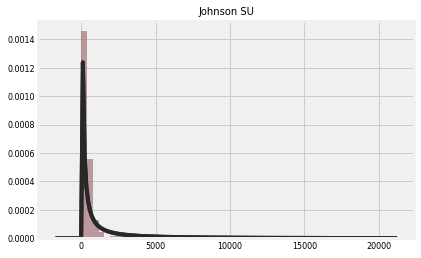

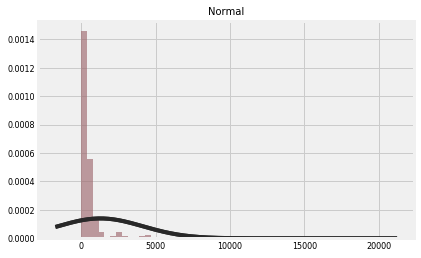

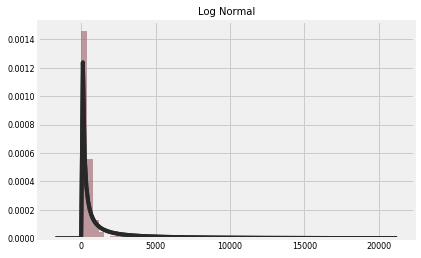

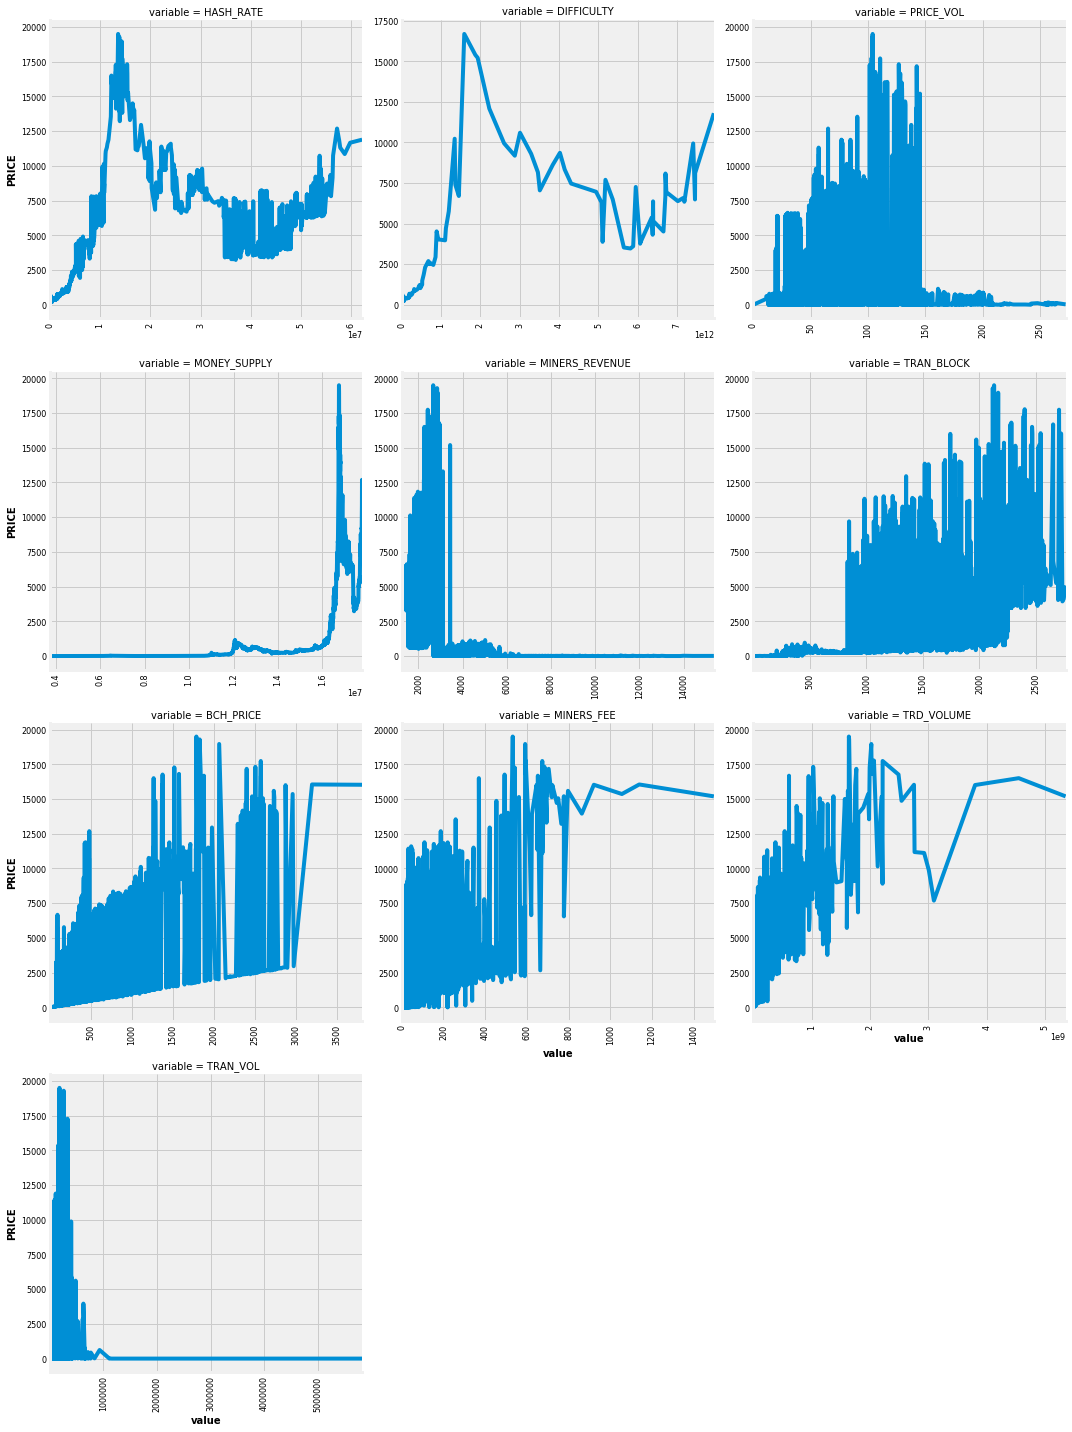

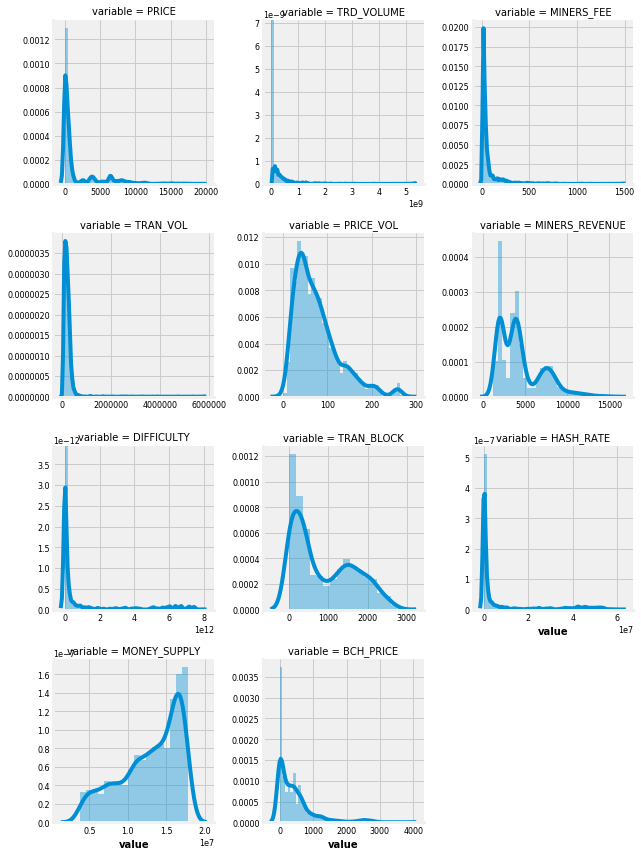

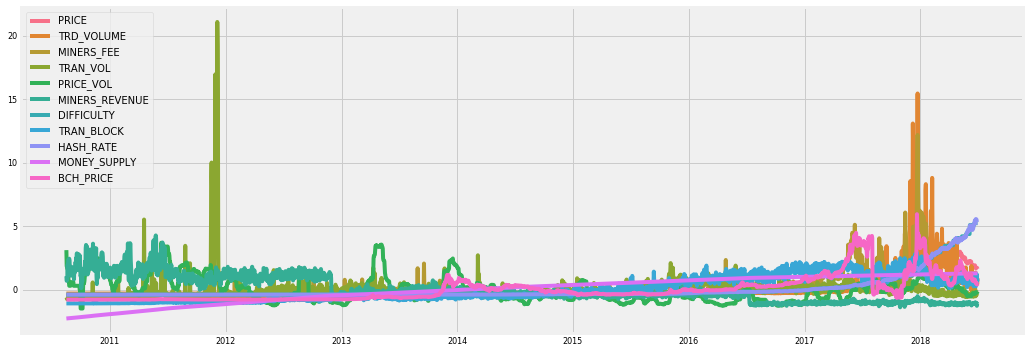

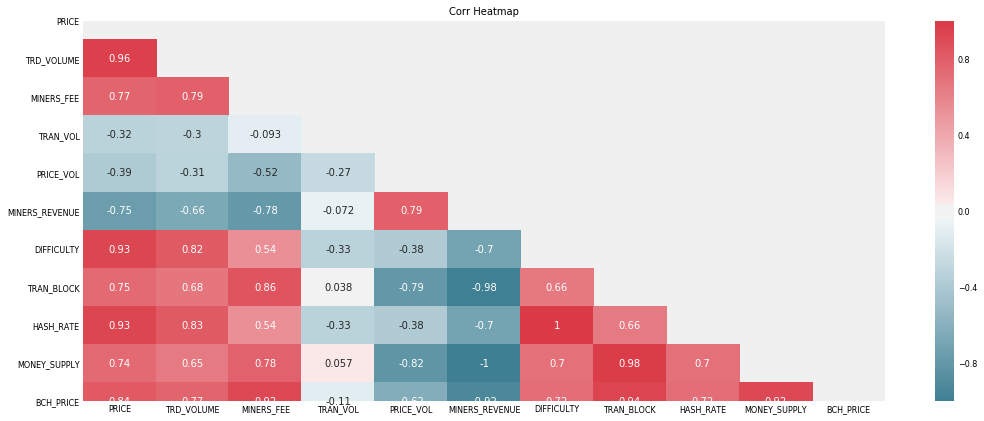

In [5]:
# lets split our data set before we do analysis on data set to make testing phase completely independent
target = 'PRICE'
base_features = btc_data.columns

train_mask = (btc_data.index >= '2010-01-01') & (btc_data.index <= '2018-06-30')
valid_mask = (btc_data.index >= '2018-07-01') & (btc_data.index <= '2018-12-31')
test_mask = (btc_data.index >= '2019-01-01') & (btc_data.index <= '2019-06-30')

X_train =  btc_data.loc[train_mask][base_features]
y_train =  pd.DataFrame(btc_data.loc[train_mask][target])

X_valid =  btc_data.loc[valid_mask][base_features]
y_valid = pd.DataFrame(btc_data.loc[valid_mask][target])

X_test =  btc_data.loc[test_mask][base_features]
y_test =  pd.DataFrame(btc_data.loc[test_mask][target])

missing = X_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)
#using constant imputer for price volatility and standard scaler for normalization
constant_imputer = SimpleImputer(strategy='constant')

#normalizer
normalizer = StandardScaler()
y_normalizer = StandardScaler()

def preprocessing_pipeline(X, train=False):
    ind = X.index
    if  train:
        X = pd.DataFrame(constant_imputer.fit_transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.fit_transform(X), columns=base_features)
    else:
        X = pd.DataFrame(constant_imputer.transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.transform(X), columns=base_features)
    X.index = ind
    return X
        
    
X_train = preprocessing_pipeline(X_train, train=True)
X_valid = preprocessing_pipeline(X_valid, train=False)
X_test = preprocessing_pipeline(X_test, train=False)

print(X_train.head())
X_train.describe()
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)
# print(list(base_features))
pairplot_with_target(btc_data, list(set(base_features) - set(['PRICE'])), 'PRICE')

plot_distributions(btc_data)

#plot all columns in same chart 
plt.figure(figsize=(16,6))

sns.lineplot(data=X_train, dashes=False)
train_corr=X_train.cov()
plot_corr_heatmap(train_corr)

highly correlated

1)Money supply and transections per block 

2)BCH price and transections per block 

3) Market cap and difficulty of mining bitcoin

4) hashrate and difficulty are almost perfectly correlated(we should drop one of thesse)

5) miners fee and bch price

6) transections per block and bch price

7) market cap and hash rate

Negatively corr

1) Miners revenue and transections per block 

2) Miners revenue and money supply(number of bitcoins)


We should drop difficulty as it is highly correlated with hashrate and trd volume.

### Observations

1) We have missing values for price volatility

2) Std dev of most of the columns is pretty high since 2010

3) We should reduce highly correlated features (this can be done using greedy algorithms or relying on L1 regularization of NNs)

4) Standardised features are not stationary which is evident from high shocks(non constant volatility) in the time series plot.



# ##benchmark

In [59]:
#### data processing Utils
def create_lagged_features(X, lag=3, dropna=False):
    """
    This function creates the lagged feature dataframe specifically useful for time series modelling
    """
    lagged_dfs = [ X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
    if dropna:
        lagged_dfs = lagged_dfs.dropna()
    return pd.concat(lagged_dfs, axis=1)

def create_leading_targets(X, lead=3, dropna=False):
    """
    This function creates leading targets specifically useful for predicting over multiple periods
    """
    leading_df = [ X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
    if dropna:
        leading_df = leading_df.dropna()
    return pd.concat(leading_df, axis=1)
def get_avg_model_preds(data, target):
    y_preds = btc_data[target].rolling(28).mean().loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

def get_last_val_preds(data, target):
    y_preds = data[target].shift(1).loc[y_valid_leading.index]
    return pd.concat([y_preds]*7, axis=1) 

X_train_lagged = create_lagged_features(X_train, lag=28)[28:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[28:-7]
X_valid_lagged = create_lagged_features(X_valid, lag=28)[28:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[28:-7]
X_test_lagged = create_lagged_features(X_test, lag=28)[28:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[28:-7]

last_val_preds = get_last_val_preds(btc_data, target)
avg_model_preds = get_avg_model_preds(btc_data, target)
unnorm_y_valid = y_normalizer.inverse_transform(y_valid_leading)
print("avg benchmark score: ", mean_absolute_error(unnorm_y_valid, avg_model_preds))
print("last val benchmark score: ", mean_absolute_error(unnorm_y_valid, last_val_preds))


plt.figure(figsize=(16,6))
plt.title('Average Model Validation Predictions(t+1)')
sns.lineplot(y_valid_leading.index, avg_model_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')
plt.xlabel('date')


plt.figure(figsize=(16,6))
plt.title('Last Value Validation Predictions(T+1)')
sns.lineplot(y_valid_leading.index, last_val_preds.iloc[:,0], label='predicted price')
sns.lineplot(y_valid_leading.index, unnorm_y_valid[:, 0], label='actual price')

plt.xlabel('date')


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [61]:
# common feature engineerng
#features using technical analysis
btc_data['ma7'] = btc_data['PRICE'].rolling(7).mean()
btc_data['20sd'] = btc_data['PRICE'].rolling(20).std()
btc_data['ma21'] = btc_data['PRICE'].rolling(window=21).mean()
    
btc_data['12ema'] = pd.DataFrame.ewm(btc_data['PRICE'], span=12).mean()


In [78]:
class DLEngine:
    
    def __init__(self, data):
        self.raw_data = data
        
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
        self.performance_history=None
        
        self.preprocess_params = {"imputer": None,
                                  "normalizer": None,
                                  "boxcox_X_lam": {},
                                  "boxcox_y_lam": None}
        self.model = {"SNN": None,
                     "LSTM": None,
                     "GRU":None}
        
        
    def train_test_split(self, base_features, target='PRICE'):
        # lets split our data set before we do analysis on data set to make testing phase completely independent
        train_mask = (self.raw_data.index >= '2010-01-01') & (self.raw_data.index <= '2018-06-30')
        valid_mask = (self.raw_data.index >= '2018-07-01') & (self.raw_data.index <= '2018-12-31')
        test_mask = (self.raw_data.index >= '2019-01-01') & (self.raw_data.index <= '2019-06-30')

        self.X_train =  self.raw_data.loc[train_mask][base_features]
        self.y_train =  pd.DataFrame(self.raw_data.loc[train_mask][target])

        self.X_valid =  self.raw_data.loc[valid_mask][base_features]
        self.y_valid = pd.DataFrame(self.raw_data.loc[valid_mask][target])

        self.X_test =  self.raw_data.loc[test_mask][base_features]
        self.y_test =  pd.DataFrame(self.raw_data.loc[test_mask][target])
    
    # preprocessing:
    def __impute(self, X, train=False, strategy='constant'):
        ind = X.index
        col = X.columns
        if train:
            #using constant imputer for price volatility and standard scaler for normalization
            self.preprocess_params["imputer"] = SimpleImputer(strategy=strategy)
            X = pd.DataFrame(self.preprocess_params["imputer"].fit_transform(X), columns=col, index=ind)
        else:
            X = pd.DataFrame(self.preprocess_params["imputer"].transform(X), columns=col, index=ind)
        return X
    
    def __boxcox(self, X, is_X=True, train=False):
        '''is_X: True, boxcox for X; False, boxcox for y
        '''
        ind = X.index
        res = pd.DataFrame(index=ind)
        for col_name, series in X.iteritems():
            if train:
                bc = boxcox(series)
                res[col_name] = bc[0]
                if is_X:
                    self.preprocess_params["boxcox_X_lam"][col_name] = bc[1]
                else:
                    self.preprocess_params["boxcox_y_lam"] = bc[1]
            else:
                if is_X:
                    lam = self.preprocess_params["boxcox_X_lam"][col_name]
                else:
                    lam = self.preprocess_params["boxcox_y_lam"]
                res[col_name] = boxcox(series, lmbda=lam)
        return res
    
    def __boxcox_inv(self, y, lmbda):
        '''inverse boxcox transformation
        '''
        if lmbda == 0:
            return np.exp(y)
        else:
            return np.power(lmbda * y + 1, 1 / lmbda)
    
    def __normalize(self, X, train=False):
        ind = X.index
        col = X.columns
        if train:
            #normalizer
            self.preprocess_params["normalizer"] = StandardScaler()
            X = pd.DataFrame(self.preprocess_params["normalizer"].fit_transform(X), columns=col, index=ind)
        else:
            X = pd.DataFrame(self.preprocess_params["normalizer"].transform(X), columns=col, index=ind)
        return X
    
    def preprocessing(self, impute=True, boxcox=True, normalize=True, **kwargs):
        '''other parameters: strategy
        '''
        if impute:
            self.X_train = self.__impute(self.X_train, train=True, strategy=kwargs['strategy'])
            self.X_valid = self.__impute(self.X_valid, train=False, strategy=kwargs['strategy'])
            self.X_test = self.__impute(self.X_test, train=False, strategy=kwargs['strategy'])
        
        if boxcox:
            self.X_train = self.__boxcox(1 + self.X_train, is_X=True, train=True)
            self.y_train = self.__boxcox(1 + self.y_train, is_X=False, train=True)
            self.X_valid = self.__boxcox(1 + self.X_valid, is_X=True, train=False)
            self.y_valid = self.__boxcox(1 + self.y_valid, is_X=False, train=False)
            self.X_test = self.__boxcox(1 + self.X_test, is_X=True, train=False)
            self.y_test = self.__boxcox(1 + self.y_test, is_X=False, train=False)
        
        if normalize:
            self.X_train = self.__normalize(self.X_train, train=True)
            self.X_valid = self.__normalize(self.X_valid, train=False)
            self.X_test = self.__normalize(self.X_test, train=False)
    
    # feature engineering:
    def __create_lagged_features(self, X, lag):
        """
        This function creates the lagged feature dataframe specifically useful for time series modelling
        """
        lagged_dfs = [X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
        return pd.concat(lagged_dfs, axis=1)

    def __create_leading_targets(self, X, lead):
        """
        This function creates leading targets specifically useful for predicting over multiple periods
        """
        leading_df = [X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
        return pd.concat(leading_df, axis=1)
  

    def __create_3d_lagged_features(self, X, lag):
        x_array=[]
        for i in range(len(X)-lag):
            x_array.append(X.iloc[i:i+lag,:].as_matrix())
        x_array=np.asarray(x_array)
        return x_array
    
    def munge(self):
        self.X_train = self.__create_lagged_features(self.X_train, lag=28)[28:-7]
        self.y_train = self.__create_leading_targets(pd.DataFrame(self.y_train), lead=7)[28:-7]
        self.X_valid = self.__create_lagged_features(self.X_valid, lag=28)[28:-7]
        self.y_valid = self.__create_leading_targets(pd.DataFrame(self.y_valid), lead=7)[28:-7]
        self.X_test = self.__create_lagged_features(self.X_test, lag=28)[28:-7]
        self.y_test = self.__create_leading_targets(pd.DataFrame(self.y_test), lead=7)[28:-7]

    def munge_3d(self):
        self.X_train = self.__create_3d_lagged_features(self.X_train, lag=28)
        self.y_train = self.__create_leading_targets(pd.DataFrame(self.y_train), lead=7)[:-28]
        self.X_valid = self.__create_3d_lagged_features(self.X_valid, lag=28)
        self.y_valid = self.__create_leading_targets(pd.DataFrame(self.y_valid), lead=7)[:-28]
        self.X_test = self.__create_3d_lagged_features(self.X_test, lag=28)
        self.y_test = self.__create_leading_targets(pd.DataFrame(self.y_test), lead=7)[:-28]

    def build_snn(self, layers, neurons, regl=0.01, summary=True):
        '''simple neural network
        '''
        self.model["SNN"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["SNN"].add(Dense(output_dim, input_dim=input_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        else:
            self.model["SNN"].add(Dense(neurons, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(regl)))
            for _ in range(layers-2):
                self.model["SNN"].add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(regl)))
            self.model["SNN"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["SNN"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["SNN"].summary())

    def build_lstm(self, layers, neurons,dropout_rate, regl=0.01, summary=True):
        '''LSTM
        '''
        self.model["LSTM"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["LSTM"].add(LSTM(output_dim, recurrent_dropout=dropout_rate,input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
        else:
            if layers==2: self.model["LSTM"].add(LSTM(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]), kernel_regularizer=regularizers.l2(regl)))
            else:             
                self.model["LSTM"].add(LSTM(neurons,recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
                for _ in range(layers-3):
                    self.model["LSTM"].add(LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(regl)))
                self.model["LSTM"].add(LSTM(neurons, kernel_regularizer=regularizers.l2(regl)))
            self.model["LSTM"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["LSTM"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["LSTM"].summary())

    def build_gru(self, layers, neurons,dropout_rate=0.5, regl=0.01, summary=True):
        '''GRU
        '''
        self.model["GRU"] = Sequential()
        input_dim = self.X_train.shape[1]
        output_dim = self.y_train.shape[1]
        if layers == 1:
            self.model["GRU"].add(GRU(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
        else:
            if layers==2: self.model["GRU"].add(GRU(output_dim,recurrent_dropout=dropout_rate, input_shape=(self.X_train.shape[1],self.X_train.shape[2]), kernel_regularizer=regularizers.l2(regl)))
            else:             
                self.model["GRU"].add(GRU(neurons,recurrent_dropout=dropout_rate, return_sequences=True, input_shape=(self.X_train.shape[1],self.X_train.shape[2]),
                                        kernel_regularizer=regularizers.l2(regl)))
                for _ in range(layers-3):
                    self.model["GRU"].add(GRU(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(regl)))
                self.model["GRU"].add(GRU(neurons, kernel_regularizer=regularizers.l2(regl)))
            self.model["GRU"].add(Dense(output_dim, activation='linear', kernel_regularizer=regularizers.l2(regl)))
        self.model["GRU"].compile(loss='mae', optimizer='adam')
        if summary:
            print(self.model["GRU"].summary())
      
    def train(self, model, epochs=40):
        """model: SNN, LSTM, GRU, RNN
        """
        self.performance_history = self.model[model].fit(self.X_train, self.y_train, epochs=epochs,
                                                         validation_data=(self.X_valid, self.y_valid))
    # predict
    def predict(self, model, X):
        y_pred = self.model[model].predict(X)
        if self.preprocess_params["boxcox_y_lam"]:
            y_pred = self.__boxcox_inv(y_pred, self.preprocess_params["boxcox_y_lam"]) - 1
        return y_pred
    
    # evaluate:
    def score(self, model, X, y_true):
        y_pred = self.predict(model, X)
        return mean_absolute_error(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))
    
    def result_evaluation(self, model):
        pyplot.plot(self.performance_history.history['loss'], label='train', color='brown')
        pyplot.plot(self.performance_history.history['val_loss'], label='valid', color='blue')
        pyplot.title(model+" training loss vs. validation loss")
        pyplot.legend()
        pyplot.show()
    
    def plot_predictions(self, model, X, y_true):
        y_pred = self.predict(model, X)
        plt.figure(figsize=(16,6))
        plt.title('Predictions(t+1)')
        sns.lineplot(self.y_valid.index, y_pred[:,0], label='predicted price t+1')
        sns.lineplot(self.y_valid.index, y_true.iloc[:, 0], label='actual price')
        plt.xlabel('date')


# Part3 Q2: Simple Neural Network

In [79]:
#simple neural network
np.random.seed(0)
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(strategy='constant')
engine.munge()
engine.build_snn(2, 50, regl=0.05, summary=True)
engine.train('SNN')
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 50)                21050     
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 357       
Total params: 21,407
Trainable params: 21,407
Non-trainable params: 0
_________________________________________________________________
None
Train on 2840 samples, validate on 149 samples
Epoch 1/40
2840/2840 [==============================] - 2s 638us/step - loss: 6.1612 - val_loss: 4.9464
Epoch 2/40
2840/2840 [==============================] - 0s 66us/step - loss: 2.8962 - val_loss: 5.5761
Epoch 3/40
2840/2840 [==============================] - 0s 67us/step - loss: 1.9658 - val_loss: 5.5426
Epoch 4/40
2840/2840 [==============================] - 0s 66us/step - loss: 1.5909 - val_loss: 4.8608
Epoch 5/40
2840/2840 [========================

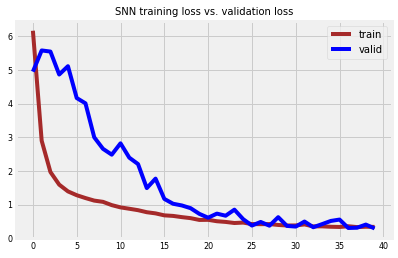

Training  error: MAE: 158.19753010813523 RMSE 592.2330175335284
validation error: MAE 411.6178602065623 RMSE 514.6103550942966
Testing error: MAE 624.524056731796 RMSE 910.8490066103695


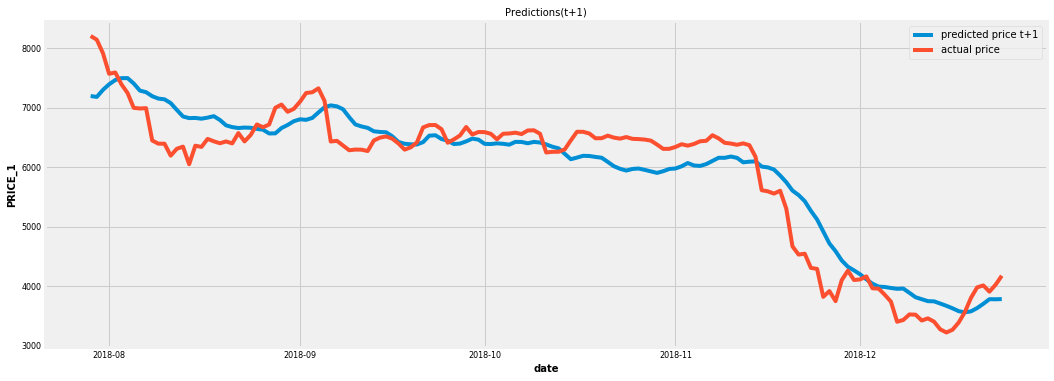

In [80]:
engine.result_evaluation('SNN')
print ("Training  error: MAE:",engine.score("SNN", engine.X_train, y_train_true)[0],
       "RMSE",engine.score("SNN", engine.X_train, y_train_true)[1])
print ("validation error: MAE",engine.score("SNN", engine.X_valid, y_valid_true)[0],      
       "RMSE",engine.score("SNN", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE",engine.score("SNN", engine.X_test, y_test_true)[0],      
       "RMSE",engine.score("SNN", engine.X_test, y_test_true)[1])

engine.plot_predictions("SNN", engine.X_valid, y_valid_true)

# Part3 Q3: LSTM

In [65]:
#LSTM
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_lstm(3, 32,dropout_rate=0.0, regl=0.0, summary=True)
engine.train('LSTM')

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Use

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 28, 32)            6144      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 231       
Total params: 14,695
Trainable params: 14,695
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 8s 3ms/step - loss: 4.0689 - val_loss: 6.0564
Epoch 2/40
2847/2847 [==============================] - 4s 1ms/step - loss: 1.2452 - val_loss: 3.7719
Epoch 3/40
2847/2847 [==============================] - 5s 2ms/step - loss: 0.6246 - val_loss: 2.6091
Epoch 4/40
2847/2847 

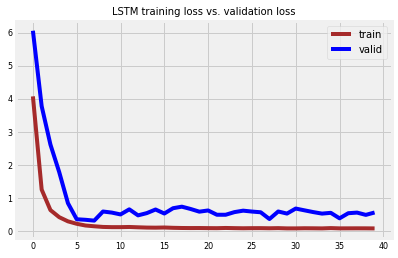

Training  error: MAE: 82.54613742908568 RMSE: 295.8229220575106
validation error: MAE: 1508.3750559453401 RMSE: 1688.3998249486967
Testing error: MAE: 1582.0634524050238 RMSE: 1687.8061229612588


In [66]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('LSTM')
print ("Training  error: MAE:",engine.score("LSTM", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("LSTM", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("LSTM", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("LSTM", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("LSTM", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("LSTM", engine.X_test, y_test_true)[1])

# Part3 Q4

In [34]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(2, 32,dropout_rate=0, regl=0.0, summary=True)
engine.train('GRU')
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
print ("Training  error:",engine.score("GRU", engine.X_train, y_train_true))
print ("validation error:",engine.score("GRU", engine.X_valid, y_valid_true))

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Use

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 7)                 504       
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 56        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 3s 1ms/step - loss: 5.8944 - val_loss: 10.7235
Epoch 2/40
2847/2847 [==============================] - 2s 752us/step - loss: 5.4852 - val_loss: 9.7505
Epoch 3/40
2847/2847 [==============================] - 2s 702us/step - loss: 4.4441 - val_loss: 8.6259
Epoch 4/40
2847/2847 [==============================] - 2s 735us/step - loss: 3.2815 - val_loss: 7.5489
Epoch 5/40
2847/2847 [=============================

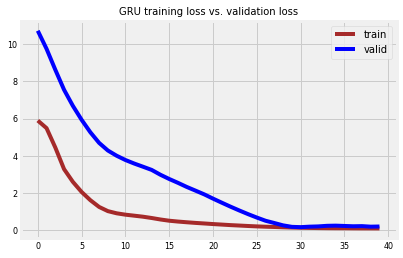

Training  error: MAE: 162.76940973374215 RMSE: 742.8518753071078
validation error: MAE: 800.6773713667623 RMSE: 918.5005267120789
Testing error: MAE: 938.3302445298631 RMSE: 1060.5365814389602


In [36]:
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])

# Part3 Q5
Build and train an RNN model with a GRU layer and recurrent dropout and print the train
and validation loss for each epoch

In [37]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(2, 32,dropout_rate=0.5, regl=0.0, summary=True)
engine.train('GRU')

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Use

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 7)                 504       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 56        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 4s 1ms/step - loss: 5.8557 - val_loss: 10.5858
Epoch 2/40
2847/2847 [==============================] - 2s 835us/step - loss: 5.4130 - val_loss: 9.5521
Epoch 3/40
2847/2847 [==============================] - 2s 800us/step - loss: 4.5814 - val_loss: 8.4417
Epoch 4/40
2847/2847 [==============================] - 2s 812us/step - loss: 3.4964 - val_loss: 7.3331
Epoch 5/40
2847/2847 [=============================

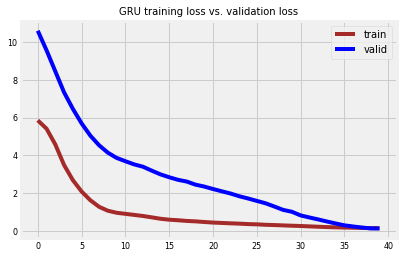

Training  error: MAE: 262.67875414573444 RMSE: 1045.902480017863
validation error: MAE: 532.9094503266682 RMSE: 753.6455553514356
Testing error: MAE: 1158.122220595698 RMSE: 1252.3773964863005


In [38]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])

# Part3 Q6
Add an additional GRU layer to (5) above with dropout and recurrent dropout and print
the train and validation loss

In [39]:
#GRU
engine = DLEngine(btc_data)
base_features = btc_data.columns
engine.train_test_split(base_features)
engine.preprocessing(boxcox=True, strategy='constant')
engine.munge_3d()
engine.build_gru(3, 32,dropout_rate=0.5, regl=0.0, summary=True)
engine.train('GRU')

/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/rohitchandel/anaconda2/envs/mfe-env/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Use

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 28, 32)            4704      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 231       
Total params: 11,175
Trainable params: 11,175
Non-trainable params: 0
_________________________________________________________________
None
Train on 2847 samples, validate on 156 samples
Epoch 1/40
2847/2847 [==============================] - 6s 2ms/step - loss: 4.5307 - val_loss: 6.5485
Epoch 2/40
2847/2847 [==============================] - 4s 2ms/step - loss: 1.4726 - val_loss: 4.0418
Epoch 3/40
2847/2847 [==============================] - 4s 2ms/step - loss: 0.7790 - val_loss: 3.1728
Epoch 4/40
2847/2847 [

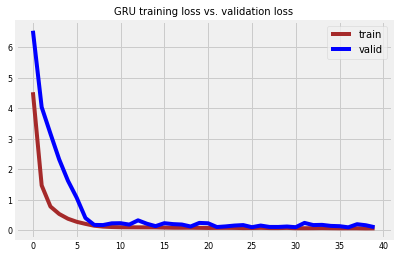

Training  error: MAE: 72.65314336069694 RMSE: 258.1274078731271
validation error: MAE: 347.38867278723467 RMSE: 437.41442756399664
Testing error: MAE: 435.9088767487475 RMSE: 494.44125340998875


In [40]:
y_train_true = engine._DLEngine__boxcox_inv(engine.y_train, engine.preprocess_params["boxcox_y_lam"]) - 1
y_valid_true = engine._DLEngine__boxcox_inv(engine.y_valid, engine.preprocess_params["boxcox_y_lam"]) - 1
y_test_true = engine._DLEngine__boxcox_inv(engine.y_test, engine.preprocess_params["boxcox_y_lam"]) - 1
engine.result_evaluation('GRU')
print ("Training  error: MAE:",engine.score("GRU", engine.X_train, y_train_true)[0],
       "RMSE:",engine.score("GRU", engine.X_train, y_train_true)[1])
print ("validation error: MAE:",engine.score("GRU", engine.X_valid, y_valid_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_valid, y_valid_true)[1])
print ("Testing error: MAE:",engine.score("GRU", engine.X_test, y_test_true)[0],      
       "RMSE:",engine.score("GRU", engine.X_test, y_test_true)[1])